## Train models on the enhanced data (with all new columns)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import ConnectionDetails, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

print(*(x[1] for x in config.items('database')))

dt = DataTransfer(ConnectionDetails(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.admissions
"""

df = dt.fetch_data(sql_query)

postgresql mimic-iv_db agabitas aGaBiTaS dws-student-01.informatik.uni-mannheim.de 5432


In [3]:
df.head()

,subject_id,hadm_id,admittime,admit_daytime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,...,hematocrit_csf_max_value,hematocrit_csf_avg_value,hematocrit_csf_ref_range_lower,hematocrit_csf_ref_range_upper,hematocrit_csf_was_abnormal,hematocrit_csf_ratio_abnormal,hematocrit_csf_first_abnormal_charttime,hematocrit_csf_first_test_charttime,hematocrit_csf_last_test_charttime,hematocrit_csf_abnormal_hrs_until_discharge
0,10004113,29879900,2173-03-20 00:00:00,night,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
1,10007785,22943998,2156-05-16 01:36:00,night,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
2,10010888,20162667,2174-01-09 22:19:00,night,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
3,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
4,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN


In [4]:
df = pd.get_dummies(df, columns=['admit_daytime'])

df = pd.get_dummies(df, columns=['marital_status'])

df = pd.get_dummies(df, columns=['race'])

df = pd.get_dummies(df, columns=['gender'])

df = pd.get_dummies(df, columns=['anchor_year_group'])

df['icd_code_numeric'] = df['icd_code'].replace({
    r'^I61.*': 'I61',   # Match codes starting with 'I61'
    r'^I63.*': 'I63',   # Match codes starting with 'I63'
    r'^G41.*': 'G41'    # Match codes starting with 'G41'
}, regex=True)

columns_to_drop = [column for column in df.columns if any(substring in column for substring in ['range', 'charttime'])]

<Axes: ylabel='Frequency'>

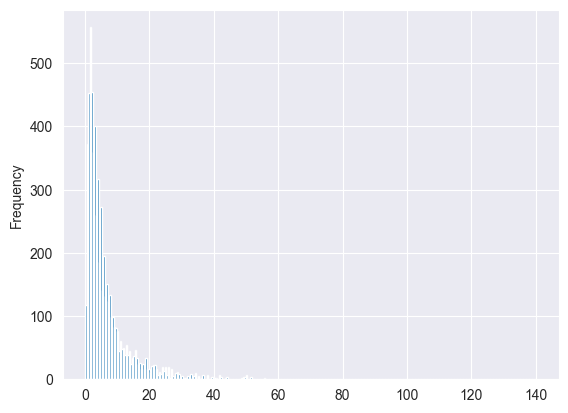

In [5]:
df['los'].plot.hist(bins=300)

In [6]:
def transform_los(los):
    if los <= 2:
        return 0
    elif 3 <= los <= 7:
        return 1
    else:
        return 2

df['los'] = df['los'].apply(transform_los)

In [7]:
df

,subject_id,hadm_id,admittime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,...,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,gender_F,gender_M,anchor_year_group_2008 - 2010,anchor_year_group_2011 - 2013,anchor_year_group_2014 - 2016,anchor_year_group_2017 - 2019,anchor_year_group_2020 - 2022,icd_code_numeric
0,10004113,29879900,2173-03-20 00:00:00,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,HOME,...,False,False,False,True,False,False,True,False,False,I61
1,10007785,22943998,2156-05-16 01:36:00,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,HOME,...,False,False,False,True,False,False,False,False,True,I63
2,10010888,20162667,2174-01-09 22:19:00,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,...,False,False,False,True,False,False,False,False,True,I63
3,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I61
4,10013310,22098926,2153-06-10 11:55:00,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,SKILLED NURSING FACILITY,...,False,False,True,False,False,False,False,True,False,I63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,19985409,27293537,2154-09-21 20:49:00,9.0,2154-09-28 14:39:00,NaT,EW EMER.,P627AF,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,...,False,False,False,True,False,False,False,True,False,I63
6170,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I61
6171,19987702,26568899,2131-01-13 16:45:00,1.0,2131-01-23 15:00:00,NaT,OBSERVATION ADMIT,P468KA,TRANSFER FROM HOSPITAL,REHAB,...,False,False,False,True,False,False,False,True,False,I63
6172,19989126,21824927,2155-01-31 01:09:00,1.0,2155-02-03 15:47:00,NaT,URGENT,P64UQ5,TRANSFER FROM HOSPITAL,HOME,...,False,False,True,False,True,False,False,False,False,I61


In [8]:
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold


cur_df = df.copy()
X = cur_df.drop('los', axis=1)
y = cur_df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


encoder = ce.BinaryEncoder(cols = [
    'first_careunit', 
    'last_careunit', 
    'admission_type',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'icd_code_numeric'
] , return_df = True)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [9]:
X_train.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',

    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

X_test.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',
    
    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [11]:
def fillna_tests(test_name: str, df: pd.DataFrame):
    df[f'{test_name}_min_value'].fillna(-1, inplace=True)
    df[f'{test_name}_max_value'].fillna(-1, inplace=True)
    df[f'{test_name}_avg_value'].fillna(-1, inplace=True)
    df[f'{test_name}_was_abnormal'].fillna(False, inplace=True)
    df[f'{test_name}_ratio_abnormal'].fillna(0, inplace=True)
    df[f'{test_name}_abnormal_hrs_until_discharge'].fillna(-1, inplace=True)

In [12]:
tests = [
    'sodium',
    'sodium_urine',
    'sodium_whole_blood',
    'potassium',
    'potassium_whole_blood',
    'calcium_total',
    'free_calcium',
    'magnesium',
    'glucose',
    'glucose_ascites',
    'glucose_body_fluid', 
    'glucose_csf',
    'lactate',
    'lactate_dehydrogenase_csf',
    'lactate_dehydrogenase_ld',
    'ph',
    'po2',
    'bicarbonate',
    'bicarbonate_urine',
    'calculated_bicarbonate_whole_blood',
    'inr_pt',
    'pt',
    'ptt',
    'crp',
    'white_blood_cells',
    'ammonia',
    'albumin',
    'albumin_creatine_urine',
    'creatinine',
    'creatinine_clearance',
    'creatinine_serum',
    'urea_nitrogen',
    'alt',
    'ast',
    'bilirubin',
    'bilirubin_direct',
    'bilirubin_indirect',
    'bilirubin_total',
    'ratio_hemoglobin_a1c',
    'hemoglobin',
    'hematocrit',
    'hematocrit_csf'
]

In [13]:
for test in tests:
    fillna_tests(test, X_train)
    fillna_tests(test, X_test)

In [16]:
print(X_train.columns[X_train.isnull().sum() > 0])

Index([], dtype='object')


In [14]:
print(X_test.columns[X_test.isnull().sum() > 0])

Index([], dtype='object')


<Axes: >

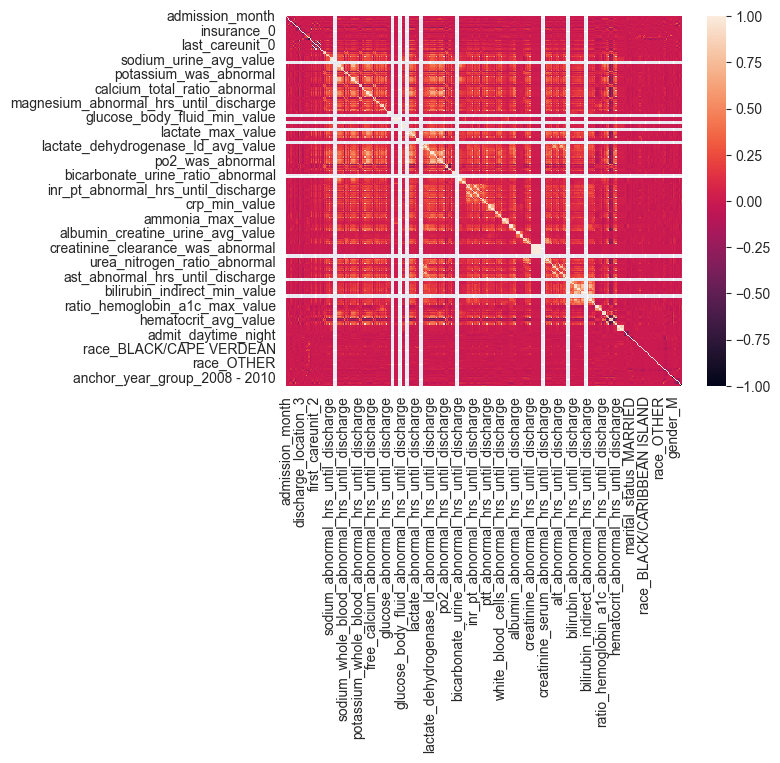

In [15]:
import seaborn as sns
%matplotlib inline

corr = X_train.corr()

sns.heatmap(corr)

In [16]:
X_train.corrwith(y_train).sort_values(ascending=False).head(21)

ph_max_value                                      0.281634
ph_avg_value                                      0.275273
ph_min_value                                      0.267898
sodium_was_abnormal                               0.245796
free_calcium_max_value                            0.242345
free_calcium_avg_value                            0.236931
calcium_total_was_abnormal                        0.230105
free_calcium_min_value                            0.230066
po2_was_abnormal                                  0.227372
ph_was_abnormal                                   0.226055
po2_max_value                                     0.221681
glucose_abnormal_hrs_until_discharge              0.221266
white_blood_cells_abnormal_hrs_until_discharge    0.213386
bicarbonate_max_value                             0.212669
hematocrit_abnormal_hrs_until_discharge           0.209292
hemoglobin_abnormal_hrs_until_discharge           0.208679
free_calcium_was_abnormal                         0.2073

In [17]:
from ml_utils import learn_models

In [18]:
X_train.head()

,admission_month,admission_type_0,admission_type_1,admission_type_2,admission_type_3,admission_location_0,admission_location_1,admission_location_2,admission_location_3,discharge_location_0,discharge_location_1,discharge_location_2,discharge_location_3,insurance_0,insurance_1,insurance_2,language_0,language_1,language_2,language_3,language_4,hospital_expire_flag,first_careunit_0,first_careunit_1,first_careunit_2,first_careunit_3,last_careunit_0,last_careunit_1,last_careunit_2,last_careunit_3,anchor_year,sodium_min_value,sodium_max_value,sodium_avg_value,sodium_was_abnormal,sodium_ratio_abnormal,sodium_abnormal_hrs_until_discharge,sodium_urine_min_value,sodium_urine_max_value,sodium_urine_avg_value,sodium_urine_was_abnormal,sodium_urine_ratio_abnormal,sodium_urine_abnormal_hrs_until_discharge,sodium_whole_blood_min_value,sodium_whole_blood_max_value,sodium_whole_blood_avg_value,sodium_whole_blood_was_abnormal,sodium_whole_blood_ratio_abnormal,sodium_whole_blood_abnormal_hrs_until_discharge,potassium_min_value,potassium_max_value,potassium_avg_value,potassium_was_abnormal,potassium_ratio_abnormal,potassium_abnormal_hrs_until_discharge,potassium_whole_blood_min_value,potassium_whole_blood_max_value,potassium_whole_blood_avg_value,potassium_whole_blood_was_abnormal,potassium_whole_blood_ratio_abnormal,potassium_whole_blood_abnormal_hrs_until_discharge,calcium_total_min_value,calcium_total_max_value,calcium_total_avg_value,calcium_total_was_abnormal,calcium_total_ratio_abnormal,calcium_total_abnormal_hrs_until_discharge,free_calcium_min_value,free_calcium_max_value,free_calcium_avg_value,free_calcium_was_abnormal,free_calcium_ratio_abnormal,free_calcium_abnormal_hrs_until_discharge,magnesium_min_value,magnesium_max_value,magnesium_avg_value,magnesium_was_abnormal,magnesium_ratio_abnormal,magnesium_abnormal_hrs_until_discharge,glucose_min_value,glucose_max_value,glucose_avg_value,glucose_was_abnormal,glucose_ratio_abnormal,glucose_abnormal_hrs_until_discharge,glucose_ascites_min_value,glucose_ascites_max_value,glucose_ascites_avg_value,glucose_ascites_was_abnormal,glucose_ascites_ratio_abnormal,glucose_ascites_abnormal_hrs_until_discharge,glucose_body_fluid_min_value,glucose_body_fluid_max_value,glucose_body_fluid_avg_value,glucose_body_fluid_was_abnormal,glucose_body_fluid_ratio_abnormal,glucose_body_fluid_abnormal_hrs_until_discharge,glucose_csf_min_value,glucose_csf_max_value,glucose_csf_avg_value,glucose_csf_was_abnormal,glucose_csf_ratio_abnormal,glucose_csf_abnormal_hrs_until_discharge,lactate_min_value,lactate_max_value,lactate_avg_value,lactate_was_abnormal,lactate_ratio_abnormal,lactate_abnormal_hrs_until_discharge,lactate_dehydrogenase_csf_min_value,lactate_dehydrogenase_csf_max_value,lactate_dehydrogenase_csf_avg_value,lactate_dehydrogenase_csf_was_abnormal,lactate_dehydrogenase_csf_ratio_abnormal,lactate_dehydrogenase_csf_abnormal_hrs_until_discharge,lactate_dehydrogenase_ld_min_value,lactate_dehydrogenase_ld_max_value,lactate_dehydrogenase_ld_avg_value,lactate_dehydrogenase_ld_was_abnormal,lactate_dehydrogenase_ld_ratio_abnormal,lactate_dehydrogenase_ld_abnormal_hrs_until_discharge,ph_min_value,ph_max_value,ph_avg_value,ph_was_abnormal,ph_ratio_abnormal,ph_abnormal_hrs_until_discharge,po2_min_value,po2_max_value,po2_avg_value,po2_was_abnormal,po2_ratio_abnormal,po2_abnormal_hrs_until_discharge,bicarbonate_min_value,bicarbonate_max_value,bicarbonate_avg_value,bicarbonate_was_abnormal,bicarbonate_ratio_abnormal,bicarbonate_abnormal_hrs_until_discharge,bicarbonate_urine_min_value,bicarbonate_urine_max_value,bicarbonate_urine_avg_value,bicarbonate_urine_was_abnormal,bicarbonate_urine_ratio_abnormal,bicarbonate_urine_abnormal_hrs_until_discharge,calculated_bicarbonate_whole_blood_min_value,calculated_bicarbonate_whole_blood_max_value,calculated_bicarbonate_whole_blood_avg_value,calculated_bicarbonate_whole_blood_was_abnormal,calculated_bicarbonate_whole_blood_ratio_abnormal,calculated_bicarbonate_whole_blood_abnormal_hrs_unt

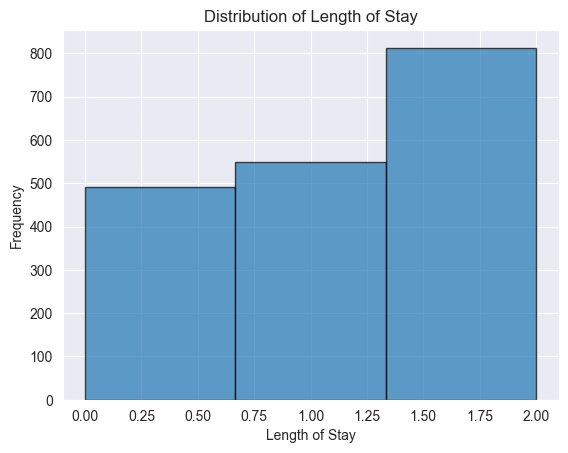

In [19]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=3, edgecolor='k', alpha=0.7)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.show()

In [20]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

initial_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            objective='reg:squarederror', 
            random_state=42
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100, 
            depth=5, 
            learning_rate=0.1,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            verbose=False
        )
    },
    dfs=[X_train, X_test, y_train, y_test],
    folder='initial_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.5256341068537507, Precision = 0.5344453153586967, Recall = 0.5256341068537507, F1-Score = [0.49812734 0.45248869 0.5975212 ]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.6184565569347005, Precision = 0.6185127067724694, Recall = 0.6184565569347005, F1-Score = [0.60064586 0.507431   0.68446866]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.6826767404209391, Precision = 0.6814910174653593, Recall = 0.6826767404209391, F1-Score = [0.69450102 0.61121495 0.72188634]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.6427415002698327, Precision = 0.6403579577281447, Recall = 0.6427415002698327, F1-Score = [0.64131552 0.54042989 0.70045558]


## Results of training

In [21]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.525634,0.534445,0.525634,"[0.49812734082397003, 0.45248868778280543, 0.5..."
1,Random Forest,0.618457,0.618513,0.618457,"[0.6006458557588805, 0.5074309978768577, 0.684..."
2,XGBoost,0.682677,0.681491,0.682677,"[0.6945010183299389, 0.611214953271028, 0.7218..."
3,CatBoost,0.642742,0.640358,0.642742,"[0.6413155190133607, 0.5404298874104401, 0.700..."


In [22]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [23]:
from ml_utils import FeatureExtractor

fe = FeatureExtractor(X_train.columns.tolist())

### KNN

In [59]:
from sklearn.inspection import permutation_importance

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importance = pd.Series(result.importances_mean, index=X_train.columns)
importance = importance.sort_values(ascending=False)

print(importance)


glucose_abnormal_hrs_until_discharge                               0.035780
white_blood_cells_abnormal_hrs_until_discharge                     0.034485
hemoglobin_abnormal_hrs_until_discharge                            0.030599
ptt_abnormal_hrs_until_discharge                                   0.027577
sodium_abnormal_hrs_until_discharge                                0.026713
inr_pt_abnormal_hrs_until_discharge                                0.025580
potassium_abnormal_hrs_until_discharge                             0.024987
hematocrit_abnormal_hrs_until_discharge                            0.022882
bicarbonate_abnormal_hrs_until_discharge                           0.022504
pt_abnormal_hrs_until_discharge                                    0.022288
urea_nitrogen_abnormal_hrs_until_discharge                         0.020615
free_calcium_abnormal_hrs_until_discharge                          0.017539
magnesium_abnormal_hrs_until_discharge                             0.015380
albumin_abno

#### Random Forest Classification

In [60]:
fe.extract_feature_importance('initial_train_classification', 'Random Forest').head(20)

glucose_abnormal_hrs_until_discharge             0.072345
hemoglobin_abnormal_hrs_until_discharge          0.044199
bicarbonate_abnormal_hrs_until_discharge         0.040093
pt_abnormal_hrs_until_discharge                  0.037019
hematocrit_abnormal_hrs_until_discharge          0.036064
white_blood_cells_abnormal_hrs_until_discharge   0.036056
inr_pt_abnormal_hrs_until_discharge              0.034719
calcium_total_abnormal_hrs_until_discharge       0.027112
ph_abnormal_hrs_until_discharge                  0.026251
urea_nitrogen_abnormal_hrs_until_discharge       0.025942
sodium_abnormal_hrs_until_discharge              0.024987
ph_max_value                                     0.024291
ptt_abnormal_hrs_until_discharge                 0.019707
po2_abnormal_hrs_until_discharge                 0.017850
last_careunit_3                                  0.017079
first_careunit_1                                 0.016480
ph_min_value                                     0.016316
last_careunit_

#### Gradient Boosting Classification

In [61]:
fe.extract_feature_importance('initial_train_classification', 'XGBoost').head(20)

glucose_abnormal_hrs_until_discharge                    0.039938
free_calcium_max_value                                  0.018424
sodium_max_value                                        0.011947
po2_abnormal_hrs_until_discharge                        0.011817
bicarbonate_abnormal_hrs_until_discharge                0.011533
first_careunit_1                                        0.011233
first_careunit_2                                        0.010896
first_careunit_3                                        0.010695
hematocrit_abnormal_hrs_until_discharge                 0.009991
hemoglobin_abnormal_hrs_until_discharge                 0.009165
ph_abnormal_hrs_until_discharge                         0.008509
hospital_expire_flag                                    0.008339
white_blood_cells_abnormal_hrs_until_discharge          0.008064
potassium_whole_blood_abnormal_hrs_until_discharge      0.007748
lactate_dehydrogenase_ld_abnormal_hrs_until_discharge   0.007668
race_WHITE - OTHER EUROPE

In [62]:
fe.extract_feature_importance('initial_train_classification', 'CatBoost').head(20)

glucose_abnormal_hrs_until_discharge             14.689340
first_careunit_3                                  6.799363
first_careunit_1                                  4.709784
sodium_max_value                                  4.449592
last_careunit_1                                   3.681753
free_calcium_max_value                            3.190835
white_blood_cells_abnormal_hrs_until_discharge    3.165690
bicarbonate_abnormal_hrs_until_discharge          2.438020
first_careunit_2                                  2.241015
hematocrit_abnormal_hrs_until_discharge           2.214119
po2_abnormal_hrs_until_discharge                  2.023246
inr_pt_abnormal_hrs_until_discharge               1.520995
hemoglobin_abnormal_hrs_until_discharge           1.432095
magnesium_avg_value                               1.420830
sodium_avg_value                                  1.384834
ptt_abnormal_hrs_until_discharge                  1.242327
calcium_total_max_value                           1.1327

## Train after feature selection

Now I'll take 20 most important features for each algorithm and will compare the results to the original ones

In [68]:
knn_top_20_features = importance.head(20).keys().tolist()
knn_X_train = X_train[X_train.columns.intersection(knn_top_20_features)]
knn_X_test = X_test[X_test.columns.intersection(knn_top_20_features)]

In [69]:
rfr_X_train, rfr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'Random Forest',
    X_train,
    X_test
)
gbr_X_train, gbr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'XGBoost',
    X_train,
    X_test
)
cbr_X_train, cbr_X_test = fe.select_k_most_relevant_features_from_df(
    20,
    'initial_train_classification',
    'CatBoost',
    X_train,
    X_test
)

In [72]:
top_20_features_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            objective='reg:squarederror',
            random_state=42
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100,
            depth=5,
            learning_rate=0.1,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            verbose=False
        )
    },
    dfs={
        'KNN': [knn_X_train, knn_X_test, y_train, y_test],
        'Random Forest': [rfr_X_train, rfr_X_test, y_train, y_test],
        'XGBoost': [gbr_X_train, gbr_X_test, y_train, y_test],
        'CatBoost': [cbr_X_train, cbr_X_test, y_train, y_test],
    },
    folder='top_20_features_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.5434430652995142, Precision = 0.5488016138883999, Recall = 0.5434430652995142, F1-Score = [0.52198316 0.47680891 0.60423348]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.6200755531570427, Precision = 0.6213402631201507, Recall = 0.6200755531570427, F1-Score = [0.58769932 0.5203252  0.68872017]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.6670264436049649, Precision = 0.6643113292534173, Recall = 0.6670264436049649, F1-Score = [0.68118812 0.57227139 0.71590232]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.6378845116028062, Precision = 0.6350197435934977, Recall = 0.6378845116028062, F1-Score = [0.63942799 0.52390852 0.69915014]


In [73]:
top_20_features_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.543443,0.548802,0.543443,"[0.5219831618334893, 0.47680890538033394, 0.60..."
1,Random Forest,0.620076,0.621340,0.620076,"[0.5876993166287016, 0.5203252032520326, 0.688..."
2,XGBoost,0.667026,0.664311,0.667026,"[0.6811881188118812, 0.5722713864306784, 0.715..."
3,CatBoost,0.637885,0.635020,0.637885,"[0.6394279877425945, 0.5239085239085239, 0.699..."


In [74]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.525634,0.534445,0.525634,"[0.49812734082397003, 0.45248868778280543, 0.5..."
1,Random Forest,0.618457,0.618513,0.618457,"[0.6006458557588805, 0.5074309978768577, 0.684..."
2,XGBoost,0.682677,0.681491,0.682677,"[0.6945010183299389, 0.611214953271028, 0.7218..."
3,CatBoost,0.642742,0.640358,0.642742,"[0.6413155190133607, 0.5404298874104401, 0.700..."


### Dimensionality Reduction for KNN

In [25]:
features_for_models = {}

In [26]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import KFold

In [79]:
knn = KNeighborsClassifier(n_neighbors=5)

sfs = SequentialFeatureSelector(knn, n_features_to_select='auto', direction='forward', cv=KFold(5), scoring='accuracy')
sfs.fit(X_train, y_train)

knn_selected_features = X_train.columns[sfs.get_support()]

# Print the results
print(f"Optimal number of features: {len(knn_selected_features)}")
print(f"Selected features: {knn_selected_features}")

X_train_selected_knn = X_train[knn_selected_features]
X_test_selected_knn = X_test[knn_selected_features]

Optimal number of features: 166
Selected features: Index(['admission_type_0', 'admission_type_1', 'admission_type_2',
       'admission_location_0', 'admission_location_1', 'admission_location_3',
       'discharge_location_0', 'discharge_location_3', 'insurance_0',
       'language_0',
       ...
       'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN',
       'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN',
       'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN',
       'anchor_year_group_2011 - 2013', 'anchor_year_group_2014 - 2016',
       'icd_code_numeric_0'],
      dtype='object', length=166)


In [82]:
features_for_models['knn'] = list(knn_selected_features)

In [83]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFECV for feature selection
rfecv_rf = RFECV(
    estimator=rf,
    step=1,  # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPUs
)

# Fit RFECV
rfecv_rf.fit(X_train_rf, y_train_rf)

# Get the selected features
selected_features_rf = X_train_rf.columns[rfecv_rf.support_]
print(f"Optimal number of features: {rfecv_rf.n_features_}")
print(f"Selected features: {list(selected_features_rf)}")

# Evaluate model on test set using the selected features
X_train_rf = rfecv_rf.transform(X_train_rf)
X_test_rf = rfecv_rf.transform(X_test_rf)

Optimal number of features: 102
Selected features: ['admission_month', 'first_careunit_1', 'first_careunit_2', 'first_careunit_3', 'last_careunit_1', 'last_careunit_2', 'last_careunit_3', 'anchor_year', 'sodium_min_value', 'sodium_max_value', 'sodium_avg_value', 'sodium_ratio_abnormal', 'sodium_abnormal_hrs_until_discharge', 'potassium_min_value', 'potassium_max_value', 'potassium_avg_value', 'potassium_abnormal_hrs_until_discharge', 'calcium_total_min_value', 'calcium_total_max_value', 'calcium_total_avg_value', 'calcium_total_ratio_abnormal', 'calcium_total_abnormal_hrs_until_discharge', 'free_calcium_max_value', 'free_calcium_avg_value', 'magnesium_min_value', 'magnesium_max_value', 'magnesium_avg_value', 'glucose_min_value', 'glucose_max_value', 'glucose_avg_value', 'glucose_ratio_abnormal', 'glucose_abnormal_hrs_until_discharge', 'lactate_min_value', 'lactate_avg_value', 'lactate_dehydrogenase_ld_min_value', 'lactate_dehydrogenase_ld_max_value', 'lactate_dehydrogenase_ld_avg_value

In [84]:
features_for_models['rf'] = list(selected_features_rf)

In [85]:
import json

with open('data_classification.json', 'w') as fp:
    json.dump(features_for_models, fp)

In [28]:
xgb_class = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

rfecv_xgb = RFECV(
    estimator=xgb_class,
    step=1,                 # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

# Load your dataset (replace X and y with your data)
# X = Feature matrix
# y = Target variable
rfecv_xgb.fit(X_train, y_train)

features_for_models['xgb'] = list(X_train.columns[rfecv_xgb.support_])

# Print results
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print("Selected features:", X_train.columns[rfecv_xgb.support_])

Optimal number of features: 171
Selected features: Index(['admission_month', 'admission_type_3', 'admission_location_1',
       'admission_location_2', 'discharge_location_0', 'discharge_location_1',
       'discharge_location_3', 'insurance_1', 'insurance_2', 'language_3',
       ...
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_HISPANIC/LATINO - PUERTO RICAN', 'race_UNABLE TO OBTAIN',
       'race_UNKNOWN', 'gender_F', 'anchor_year_group_2008 - 2010',
       'anchor_year_group_2011 - 2013', 'anchor_year_group_2017 - 2019',
       'anchor_year_group_2020 - 2022'],
      dtype='object', length=171)


In [88]:
catboost_classifier = CatBoostClassifier(
    iterations=100,
    depth=5,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False
)

rfecv_cb = RFECV(
    estimator=catboost_classifier,
    step=1,                 # Number of features to remove at each iteration
    scoring='accuracy',
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1               # Use all available CPU cores
)

rfecv_cb.fit(X_train, y_train)

features_for_models['cb'] = list(X_train.columns[rfecv_cb.support_])

print(f"Optimal number of features: {rfecv_cb.n_features_}")
print("Selected features:", X_train.columns[rfecv_cb.support_])

Optimal number of features: 29
Selected features: Index(['first_careunit_1', 'first_careunit_2', 'first_careunit_3',
       'last_careunit_1', 'last_careunit_3', 'sodium_max_value',
       'sodium_avg_value', 'sodium_abnormal_hrs_until_discharge',
       'potassium_whole_blood_min_value', 'calcium_total_max_value',
       'calcium_total_ratio_abnormal', 'free_calcium_max_value',
       'magnesium_avg_value', 'glucose_avg_value', 'glucose_ratio_abnormal',
       'glucose_abnormal_hrs_until_discharge', 'lactate_ratio_abnormal',
       'ph_max_value', 'ph_abnormal_hrs_until_discharge', 'po2_avg_value',
       'po2_abnormal_hrs_until_discharge',
       'bicarbonate_abnormal_hrs_until_discharge', 'pt_avg_value',
       'ptt_ratio_abnormal', 'white_blood_cells_avg_value',
       'white_blood_cells_abnormal_hrs_until_discharge',
       'creatinine_avg_value', 'hemoglobin_abnormal_hrs_until_discharge',
       'hematocrit_abnormal_hrs_until_discharge'],
      dtype='object')


In [30]:
import json

with open('data_classification.json') as f:
    selected_features = json.load(f)

### Hyperparameter Optimization

In [48]:
import optuna
from sklearn.model_selection import cross_val_score

In [34]:
X_train_knn_selected = X_train[selected_features['knn']]
X_test_knn_selected = X_test[selected_features['knn']]

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)  # Number of neighbors
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])  # Weight function
    p = trial.suggest_int("p", 1, 2)  # Minkowski metric: p=1 (Manhattan), p=2 (Euclidean)

    # Create the KNN model with the current hyperparameters
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)

    # Perform cross-validation and return the mean accuracy as the optimization objective
    score = cross_val_score(knn, X_train_knn_selected, y_train, cv=5, scoring="accuracy").mean()

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

knn_best_params = study.best_params

print("Best Hyperparameters:")
print(knn_best_params)

[I 2025-01-08 21:04:46,479] A new study created in memory with name: no-name-45e205dc-47d3-4933-994f-cbeb44275508
[I 2025-01-08 21:04:47,007] Trial 0 finished with value: 0.5764857632198672 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.5764857632198672.
[I 2025-01-08 21:04:47,429] Trial 1 finished with value: 0.6519348105330763 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.6519348105330763.
[I 2025-01-08 21:04:47,819] Trial 2 finished with value: 0.5521919824448726 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6519348105330763.
[I 2025-01-08 21:04:47,974] Trial 3 finished with value: 0.5216369621066154 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6519348105330763.
[I 2025-01-08 21:04:48,091] Trial 4 finished with value: 0.6183748126739458 and parameters: {'n_neighbors': 35, 'weights': 

Best Hyperparameters:
{'n_neighbors': 19, 'weights': 'distance', 'p': 1}


In [37]:
X_train_rf_selected = X_train[selected_features['rf']]
X_test_rf_selected = X_test[selected_features['rf']]

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 2000)  # Number of trees
    max_depth = trial.suggest_int("max_depth", 3, 50)  # Maximum depth of the tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # Minimum samples in a leaf
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Max features to consider

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf, X_train_rf_selected, y_train, cv=5, scoring="accuracy").mean()
    return score


study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50)

rf_best_params = study.best_params
print("Best Hyperparameters:")
print(rf_best_params)

[I 2025-01-08 21:14:02,405] A new study created in memory with name: no-name-73fd8002-527e-4756-a93d-1c8e0fecfc32
[I 2025-01-08 21:14:11,635] Trial 0 finished with value: 0.6313375080282595 and parameters: {'n_estimators': 1517, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6313375080282595.
[I 2025-01-08 21:16:13,313] Trial 1 finished with value: 0.6605012309997859 and parameters: {'n_estimators': 1718, 'max_depth': 50, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.6605012309997859.
[I 2025-01-08 21:16:17,705] Trial 2 finished with value: 0.647307856989938 and parameters: {'n_estimators': 681, 'max_depth': 50, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.6605012309997859.
[I 2025-01-08 21:16:21,017] Trial 3 finished with value: 0.6440703275529864 and parameters: {'n_estimators': 422, 'max_depth': 18,

Best Hyperparameters:
{'n_estimators': 502, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

X_train_xgb_selected = X_train[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

X_train_xgb_selected_val = X_train_xgb_selected.values
y_train_val = y_train.values


# X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
#     X_train_xgb_selected_val, y_train_val, test_size=0.2, random_state=42
# )

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),  # Number of trees
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # Maximum depth of a tree
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.3, log=True),  # Learning rate
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),  # Subsample ratio of training instances
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Subsample ratio of columns
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),  # L2 regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Initialize the XGBoost Regressor with the suggested hyperparameters
    model = xgb.XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
    )

    # score = cross_val_score(
    #     model,
    #     X_train_xgb_selected,
    #     y_train,
    #     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    #     scoring='f1_weighted'
    # ).mean()
    # return score
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, valid_index in skf.split(X_train_xgb_selected, y_train):
        X_train_split, X_valid_split = X_train_xgb_selected_val[train_index], X_train_xgb_selected_val[valid_index]
        y_train_split, y_valid_split = y_train_val[train_index], y_train_val[valid_index]

        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, eval_metric='mlogloss', early_stopping_rounds=50,)

        model.fit(
            X_train_split,
            y_train_split,
            eval_set=[(X_valid_split, y_valid_split)],
            verbose=False
        )

        preds = model.predict(X_valid_split)
        scores.append(accuracy_score(y_valid_split, preds))

    return sum(scores) / len(scores)  # Average accuracy across folds


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

xgb_best_params = study.best_params

print("Best Hyperparameters:")
print(xgb_best_params)

[I 2025-01-09 16:00:44,007] A new study created in memory with name: no-name-f8907c0c-c153-4488-b00d-60b26412b47e
[I 2025-01-09 16:01:05,252] Trial 0 finished with value: 0.6142073431813316 and parameters: {'n_estimators': 805, 'max_depth': 5, 'learning_rate': 0.009781521163722504, 'subsample': 0.7773399722081253, 'colsample_bytree': 0.9426072012014199, 'gamma': 1.0879920064027355, 'reg_alpha': 18.779808341604095, 'reg_lambda': 11.800161127508416, 'min_child_weight': 8}. Best is trial 0 with value: 0.6142073431813316.
[I 2025-01-09 16:01:45,930] Trial 1 finished with value: 0.6005507385998715 and parameters: {'n_estimators': 1070, 'max_depth': 10, 'learning_rate': 0.00282123924982785, 'subsample': 0.8229981441280485, 'colsample_bytree': 0.7426893542578137, 'gamma': 1.900665125750285, 'reg_alpha': 17.73255925985154, 'reg_lambda': 13.214089974351808, 'min_child_weight': 3}. Best is trial 0 with value: 0.6142073431813316.
[I 2025-01-09 16:02:09,030] Trial 2 finished with value: 0.58874545

In [39]:
X_train_cb_selected = X_train[selected_features['cb']]
X_test_cb_selected = X_test[selected_features['cb']]

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),  # Number of boosting iterations
        "depth": trial.suggest_int("depth", 3, 10),  # Depth of the tree
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Learning rate
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),  # L2 regularization
        "border_count": trial.suggest_int("border_count", 32, 255),  # Number of splits for numerical features
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),  # Subsample temperature
        "random_strength": trial.suggest_float("random_strength", 0, 10),  # Random noise applied to features
    }

    # Initialize the CatBoost Regressor with suggested hyperparameters
    model = CatBoostClassifier(
        **params,
        random_state=42,
        thread_count=-1,
        verbose=0
    )

    score = cross_val_score(model, X_train_cb_selected, y_train, cv=5, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50)

cb_best_params = study.best_params

print("Best hyperparameters:", cb_best_params)

[I 2025-01-08 22:19:52,571] A new study created in memory with name: no-name-60af53c7-b6a1-4969-a11d-3281753b50c5
[I 2025-01-08 22:20:06,063] Trial 0 finished with value: 0.6593411475058873 and parameters: {'iterations': 1322, 'depth': 5, 'learning_rate': 0.02673930995946748, 'l2_leaf_reg': 1.122039266798204, 'border_count': 178, 'bagging_temperature': 0.8878333715951626, 'random_strength': 1.6552235610683708}. Best is trial 0 with value: 0.6593411475058873.
[I 2025-01-08 22:20:35,972] Trial 1 finished with value: 0.6667469492614002 and parameters: {'iterations': 489, 'depth': 10, 'learning_rate': 0.19544688802669738, 'l2_leaf_reg': 2.6738993388386234, 'border_count': 140, 'bagging_temperature': 0.7618828214665486, 'random_strength': 5.466918386027675}. Best is trial 1 with value: 0.6667469492614002.
[I 2025-01-08 22:20:47,221] Trial 2 finished with value: 0.6287912117319632 and parameters: {'iterations': 1001, 'depth': 6, 'learning_rate': 0.011638676646003017, 'l2_leaf_reg': 5.1765733

Best hyperparameters: {'iterations': 912, 'depth': 9, 'learning_rate': 0.07157815481386484, 'l2_leaf_reg': 9.85535564094508, 'border_count': 120, 'bagging_temperature': 0.39170873783968363, 'random_strength': 0.21465284482602304}


In [49]:
len(list(X_train_cb_selected.columns))

161

In [50]:
for k, v in zip(X_train_cb_selected, X_test_cb_selected):
    if k != v:
        print(k, v)

In [42]:
optimized_results = learn_models(
    models={
        'KNN': KNeighborsClassifier(**knn_best_params),
        'Random Forest': RandomForestClassifier(**rf_best_params),
        'XGBoost': xgb.XGBClassifier(**xgb_best_params),
        'CatBoost': CatBoostClassifier(**cb_best_params, verbose=0)
    },
    dfs={
        'KNN': [X_train_knn_selected, X_test_knn_selected, y_train, y_test],
        'Random Forest': [X_train_rf_selected, X_test_rf_selected, y_train, y_test],
        'XGBoost': [X_train_xgb_selected, X_test_xgb_selected, y_train, y_test],
        'CatBoost': [X_train_cb_selected, X_test_cb_selected, y_train, y_test],
    },
    folder='optimized_train_classification',
    regression=False
)

Training KNN...
KNN (Classification): Accuracy = 0.6492174851592013, Precision = 0.6478243111662719, Recall = 0.6492174851592013, F1-Score = [0.63169165 0.57570093 0.70505288]
Training Random Forest...
Random Forest (Classification): Accuracy = 0.7010253642741501, Precision = 0.7002721246659712, Recall = 0.7010253642741501, F1-Score = [0.68951194 0.64819945 0.74216867]
Training XGBoost...
XGBoost (Classification): Accuracy = 0.7096600107933081, Precision = 0.7089609420028321, Recall = 0.7096600107933081, F1-Score = [0.70707071 0.65488372 0.74710542]
Training CatBoost...
CatBoost (Classification): Accuracy = 0.7058823529411765, Precision = 0.7060933440514218, Recall = 0.7058823529411765, F1-Score = [0.70381837 0.64311594 0.74954072]


In [43]:
optimized_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.649217,0.647824,0.649217,"[0.6316916488222698, 0.5757009345794393, 0.705..."
1,Random Forest,0.701025,0.700272,0.701025,"[0.6895119418483905, 0.6481994459833795, 0.742..."
2,XGBoost,0.709660,0.708961,0.709660,"[0.7070707070707071, 0.6548837209302325, 0.747..."
3,CatBoost,0.705882,0.706093,0.705882,"[0.7038183694530443, 0.6431159420289855, 0.749..."


In [101]:
initial_results

,model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.525634,0.534445,0.525634,"[0.49812734082397003, 0.45248868778280543, 0.5..."
1,Random Forest,0.618457,0.618513,0.618457,"[0.6006458557588805, 0.5074309978768577, 0.684..."
2,XGBoost,0.682677,0.681491,0.682677,"[0.6945010183299389, 0.611214953271028, 0.7218..."
3,CatBoost,0.642742,0.640358,0.642742,"[0.6413155190133607, 0.5404298874104401, 0.700..."


### Analyzing loss of XGBoost

In [67]:
X_train_xgb_selected = X_train[selected_features['xgb']]
X_test_xgb_selected = X_test[selected_features['xgb']]

xgb_best_params = {
    'n_estimators': 1401,
    'max_depth': 10,
    'learning_rate': 0.007373508765478655,
    'subsample': 0.999387540319488,
    'colsample_bytree': 0.5751155561834316,
    'gamma': 0.0005165119704802438,
    'reg_alpha': 6.356751218914768,
    'reg_lambda': 19.378874085838913,
    'min_child_weight': 5
}

eval_set = [(X_train_xgb_selected, y_train), (X_test_xgb_selected, y_test)]
eval_metric = "mlogloss"

xgb_model = xgb.XGBClassifier(**xgb_best_params, eval_metric=eval_metric)
xgb_model.fit(X_train_xgb_selected, y_train, eval_set=eval_set)

[0]	validation_0-mlogloss:1.09594	validation_1-mlogloss:1.09631
[1]	validation_0-mlogloss:1.09344	validation_1-mlogloss:1.09420
[2]	validation_0-mlogloss:1.09087	validation_1-mlogloss:1.09211
[3]	validation_0-mlogloss:1.08816	validation_1-mlogloss:1.08992
[4]	validation_0-mlogloss:1.08556	validation_1-mlogloss:1.08777
[5]	validation_0-mlogloss:1.08306	validation_1-mlogloss:1.08578
[6]	validation_0-mlogloss:1.08070	validation_1-mlogloss:1.08385
[7]	validation_0-mlogloss:1.07817	validation_1-mlogloss:1.08171
[8]	validation_0-mlogloss:1.07575	validation_1-mlogloss:1.07982
[9]	validation_0-mlogloss:1.07330	validation_1-mlogloss:1.07783
[10]	validation_0-mlogloss:1.07076	validation_1-mlogloss:1.07577
[11]	validation_0-mlogloss:1.06846	validation_1-mlogloss:1.07394
[12]	validation_0-mlogloss:1.06593	validation_1-mlogloss:1.07184
[13]	validation_0-mlogloss:1.06353	validation_1-mlogloss:1.06982
[14]	validation_0-mlogloss:1.06105	validation_1-mlogloss:1.06774
[15]	validation_0-mlogloss:1.05874	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5751155561834316, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.0005165119704802438, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.007373508765478655, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1401, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

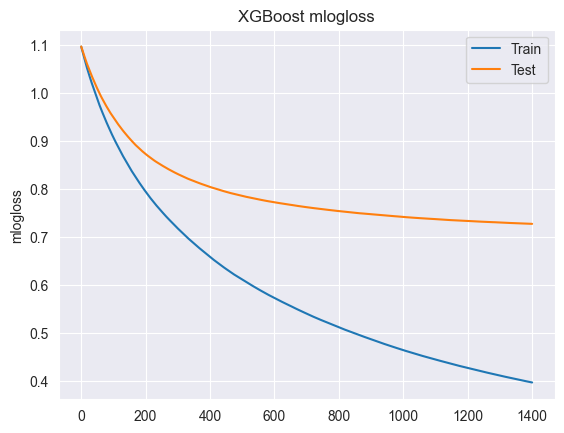

In [68]:
from matplotlib import pyplot

results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

ig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('mlogloss')
pyplot.title('XGBoost mlogloss')
pyplot.show()